In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io import wavfile
from echohiding import echo_hide, extract_echo_bits, get_odg_distortion, get_mp3_encoded
import os
import subprocess

## Experiment 1: Berr And ODG for Echo Hiding Varying $\alpha$

In [2]:
# Load audio samples from a randomly chosen example from OpenMic Dataset
sr, x = wavfile.read("086799_0.wav")
x = np.mean(x, axis=1) # Mix to mono
x = x/32768 # Put in range [-1, 1]

In [3]:
# Make some random bits
np.random.seed(0)
b = np.random.randint(0, 2, 430)

# Choose window length for echoes.  Higher window lengths
# may lead to more robust encoding, but at a lower bitrate
L = 1024
print("Payload: {} bits per second".format(sr//L))

Payload: 43 bits per second


In [4]:
N = 100
alphas = np.linspace(0.01, 1, N)
berrs = np.zeros(N)
berrs_mp3_64 = np.zeros(N)
berrs_mp3_128 = np.zeros(N)
odgs  = np.zeros(N)
dis   = np.zeros(N)
ys = []
for i, alpha in enumerate(alphas):
    if i%10 == 0:
        print(".", end="")
    y = echo_hide(x, L, b, alpha=alpha)
    ys.append(y)
    b_est = extract_echo_bits(y, L)
    berrs[i] = 1-np.sum(b==b_est)/b.size
    odgs[i], dis[i] = get_odg_distortion(x, y, sr)
    
    b_est = extract_echo_bits(get_mp3_encoded(y, sr, 64), L)
    berrs_mp3_64[i] = 1-np.sum(b==b_est)/b.size
    
    b_est = extract_echo_bits(get_mp3_encoded(y, sr, 128), L)
    berrs_mp3_128[i] = 1-np.sum(b==b_est)/b.size

..........

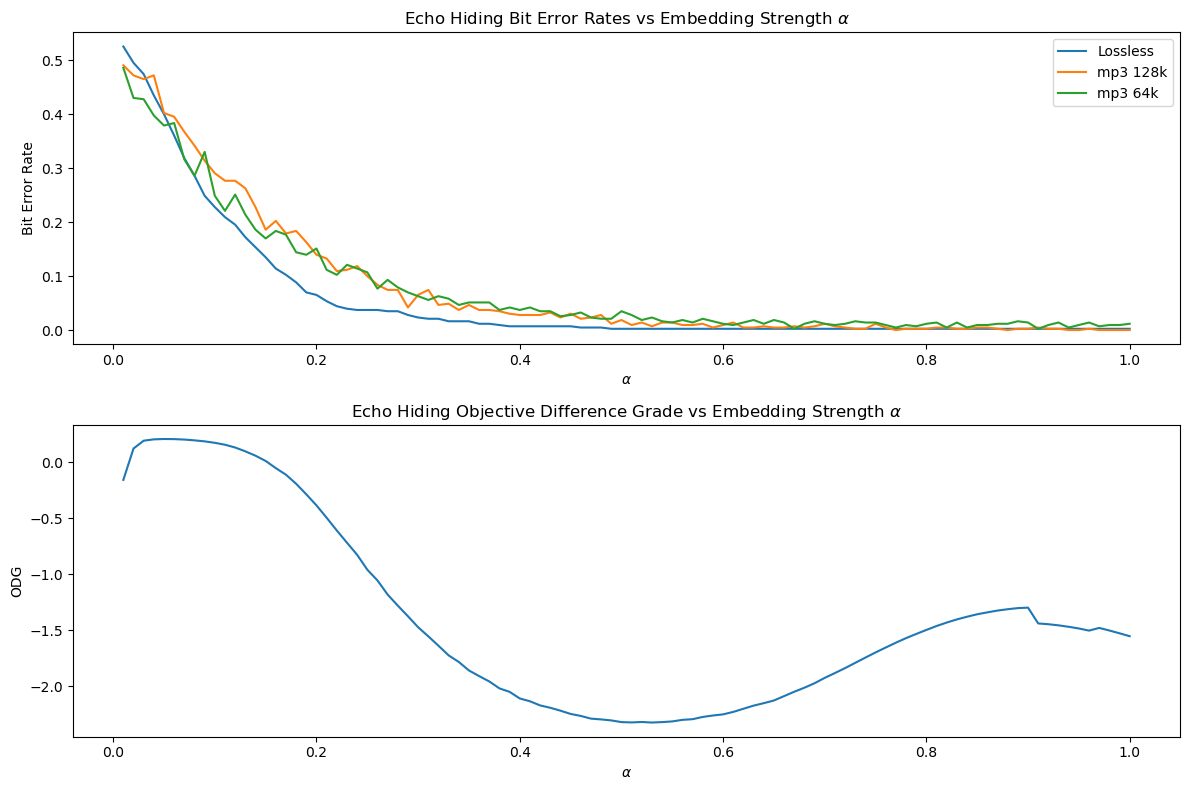

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(alphas, berrs)
plt.plot(alphas, berrs_mp3_128)
plt.plot(alphas, berrs_mp3_64)
plt.legend(["Lossless", "mp3 128k", "mp3 64k"])
#plt.ylim([0, 0.3])
plt.xlabel("$\\alpha$")
plt.ylabel("Bit Error Rate")
plt.title("Echo Hiding Bit Error Rates vs Embedding Strength $\\alpha$")

plt.subplot(212)
plt.plot(alphas, odgs)
plt.title("Echo Hiding Objective Difference Grade vs Embedding Strength $\\alpha$")
plt.xlabel("$\\alpha$")
plt.ylabel("ODG")
plt.tight_layout()

## Experiment 2: ODG Varying Uniform Added Noise

In [6]:
sr, x = wavfile.read("086799_0.wav")
x = np.mean(x, axis=1) # Mix to mono
x = 0.5*x/np.max(np.abs(x)) # Put in range [-0.5, 0.5]

In [7]:
N = 100
noises = np.linspace(0.01, 1, N)
odgs_noise   = np.zeros(N)
dis_noise    = np.zeros(N)
ys_noise = []
for i, noise in enumerate(noises):
    y = x + noise*(np.random.rand(x.size)-0.5)
    ys_noise.append(y)
    odgs_noise[i], dis_noise[i] = get_odg_distortion(x, y, sr)

Text(0.5, 1.0, 'Objective Difference Grade vs Uniform Noise')

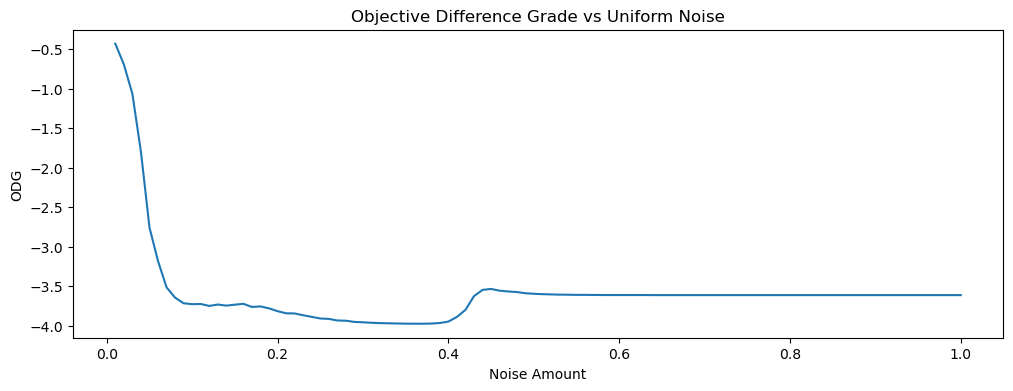

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(noises, odgs_noise)
plt.xlabel("Noise Amount")
plt.ylabel("ODG")
plt.title("Objective Difference Grade vs Uniform Noise")